In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools as it
from itertools import count, product
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa import stattools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#  **I. Data Aquisition**

In [3]:
# Load the dataset
df = pd.read_csv(r"C:/Users/maxsu/Capstone 3/daily_sunspots_time_series_1850_2023.csv")

# Display the first few rows of the DataFrame
df.head(-5)

,date,year,month,day,date_frac,counts,std,nobs,indicator
0,1850-01-01,1850,1,1,1850.001,253,19.6,1,NaN
1,1850-01-02,1850,1,2,1850.004,162,15.5,1,NaN
2,1850-01-03,1850,1,3,1850.007,217,18.1,1,NaN
3,1850-01-04,1850,1,4,1850.010,99,12.0,1,NaN
4,1850-01-05,1850,1,5,1850.012,108,12.6,1,NaN
...,...,...,...,...,...,...,...,...,...
63420,2023-08-22,2023,8,22,2023.640,115,13.3,45,*
63421,2023-08-23,2023,8,23,2023.642,105,13.2,39,*
63422,2023-08-24,2023,8,24,2023.645,91,11.6,39,*
63423,2023-08-25,2023,8,25,2023.648,89,10.3,34,*


In [4]:
df.describe()

,year,month,day,date_frac,counts,std,nobs
count,63430.000000,63430.000000,63430.000000,63430.000000,63430.000000,63430.000000,63430.000000
mean,1936.333864,6.515371,15.729276,1936.833224,83.279000,7.043643,5.893473
std,50.133512,3.447232,8.800016,50.133235,76.942528,4.435198,9.861609
min,1850.000000,1.000000,1.000000,1850.001000,0.000000,0.000000,1.000000
25%,1893.000000,4.000000,8.000000,1893.415750,21.000000,3.400000,1.000000
50%,1936.000000,7.000000,16.000000,1936.833500,63.000000,6.600000,1.000000
75%,1980.000000,10.000000,23.000000,1980.249250,128.000000,9.900000,1.000000
max,2023.000000,12.000000,31.000000,2023.664000,528.000000,77.700000,69.000000


In [5]:
#See if there are any NaN values and drop them
pd.isna(df).sum()

date             0
year             0
month            0
day              0
date_frac        0
counts           0
std              0
nobs             0
indicator    63277
dtype: int64

#  II. **Exploratory Data Analysis**

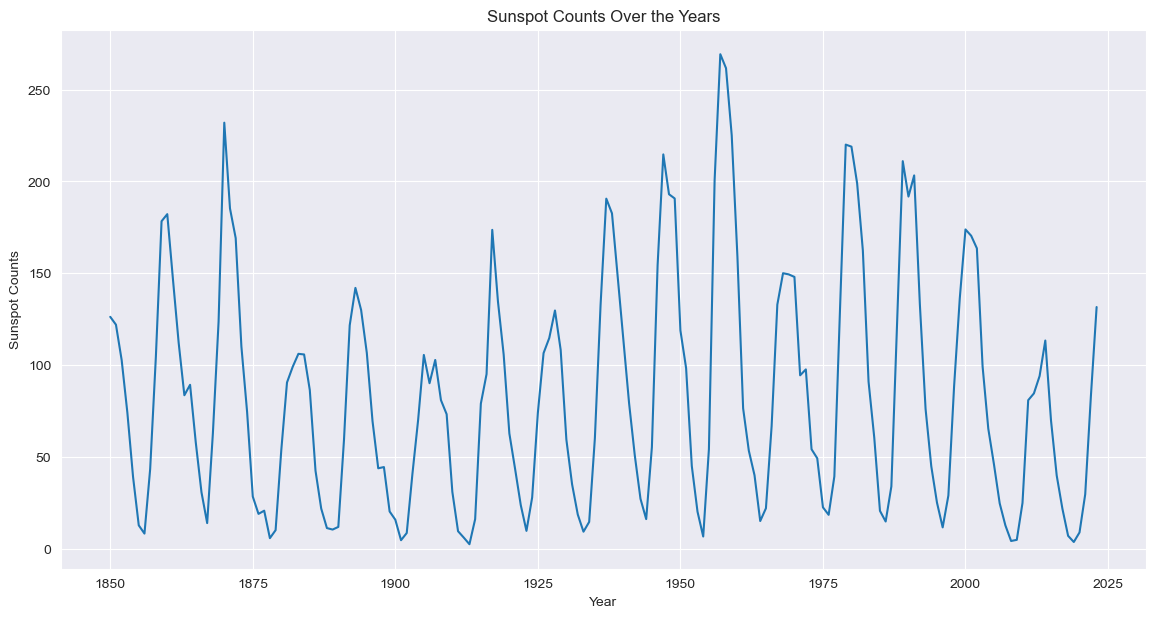

In [6]:
# Distribution of sunspot counts over the years
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))

# Sunspot counts over the years
sns.lineplot(data=df, x='year', y='counts', errorbar=None)
plt.title('Sunspot Counts Over the Years')
plt.xlabel('Year')
plt.ylabel('Sunspot Counts')
plt.show()

    This graph illustrates the cyclical nature of sunspots following the roughly 11 year solar cycle (I say roughly because it has a +/- of 0.5 years) of the magnetosphere of the Sun. We can also see that the maxima of amplitude have a highly variability. This is a question for which I hope to be able to answer after this project is concluded. 

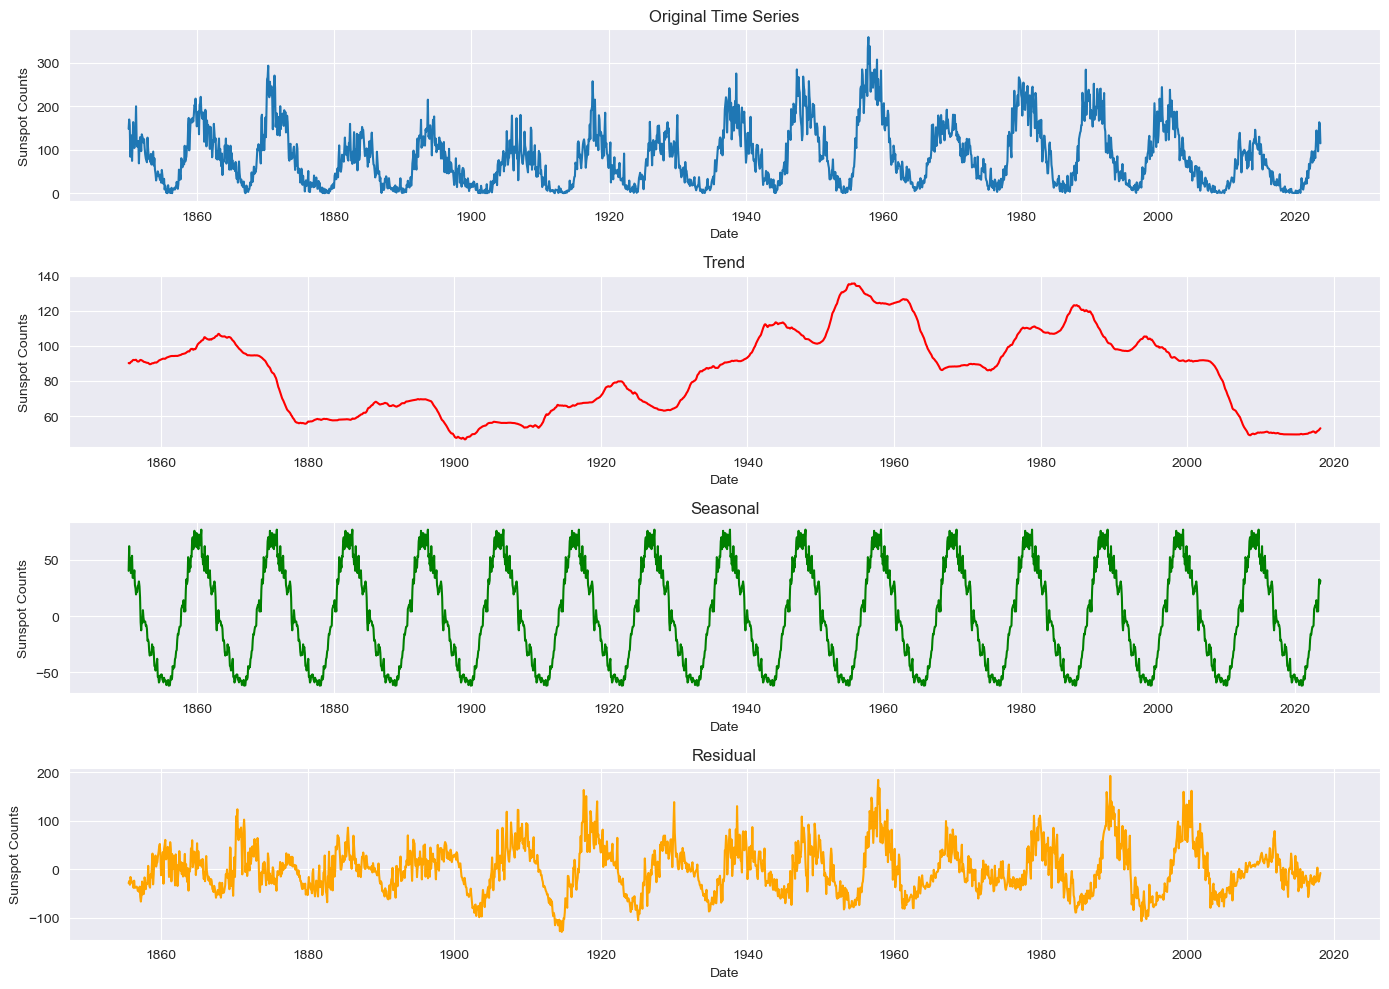

In [28]:
df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('Date', inplace=True)
monthly_avg = df['counts'].resample('M').mean()


# Decomposing the time series of average sunspot counts(monthly)
decomposition = seasonal_decompose(monthly_avg['1850':'2023'], period=132)  # Using a period of 132 months (11 years) for decomposition

# Plotting components
plt.figure(figsize=(14, 10))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(monthly_avg['1850':'2023'], label='Original')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Sunspot Counts')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Sunspot Counts')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Sunspot Counts')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='orange')
plt.title('Residual')
plt.xlabel('Date')
plt.ylabel('Sunspot Counts')


plt.tight_layout()
plt.show()

-The original time series                                                                        
-The trend component shows the long term flucations in the intensity of the solar cycle          
-The seasonal component displays the 11-year solar cycle                                        
-The residual companent displays the noise not captured by the trend or seasonal component.

In [29]:
# Add a 'time' column and set it as the index
df['Date']=pd.to_datetime(df[['year', 'month', 'day']])
df.index = df['Date']

In [30]:
# Replace the NaN by linear interpolation 
df['counts'].interpolate(method='linear', inplace=True)

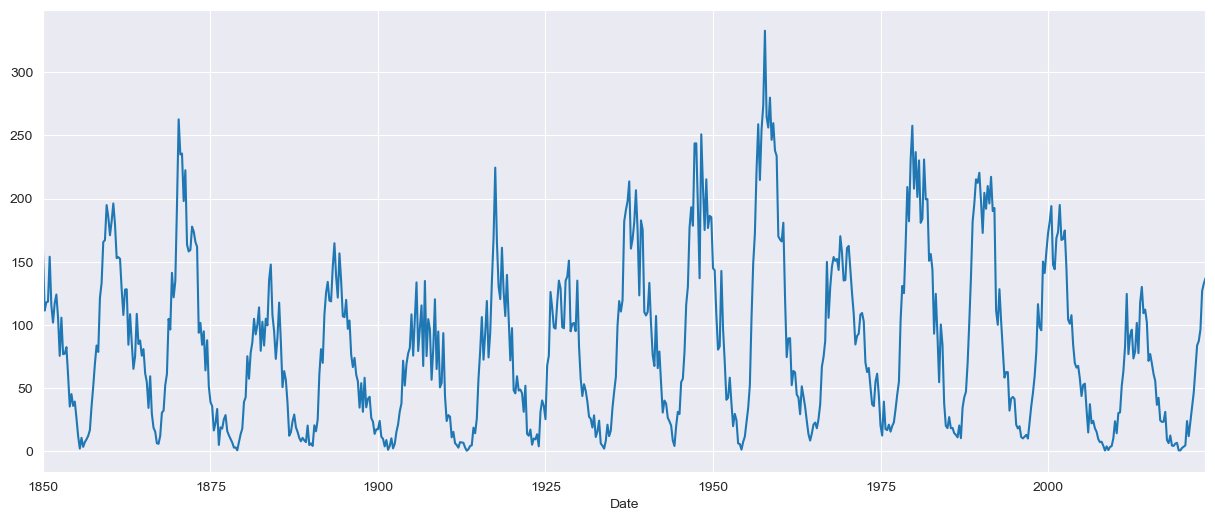

In [38]:
ts = pd.Series(data=df['counts'], index=df.index)
train = ts['1850-01-01':'2011-01-01']
test = ts['2011-01-02' : '2023-08-26']
ts_month = ts.resample('MS').mean()
ts_quarter = ts.resample('Q').mean()
ts_quarter.plot(figsize = (15,6))
plt.show()

In order to configure either an ARIMA(p,d,q) or a SARIMA(p,d,q)(P,D,Q)S model, two kind of hyperparameters have to be set

Trend parameters:                                                                 
p: The number of lag observations included in the model, also called the lag order.               
d: The number of times that the raw observations are differenced                      
q: The size of the moving average window, also called the order of moving average.     

Seasonal parameters:                                                                          
P: Seasonal autoregressive order.                                       
D: Seasonal order of differencing.                                                               
Q: Seasonal moving average order.                                                
S: The number of time steps for a single seasonal period.

# **III. Data Preprocessing and Modelling**

In [43]:
#We can utilize the graphing of Autocorreation and Partial Autocorrelation functions to help us determine the 
#hyperparametrs, (p,d,q) & (P,D,Q)

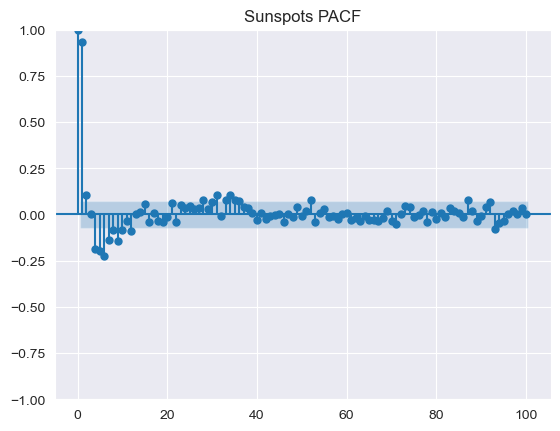

In [39]:
plot_pacf(ts_quarter,lags=100,title='Sunspots PACF')
plt.show()

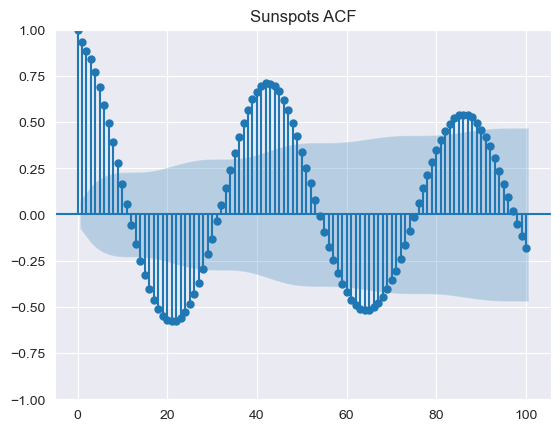

In [41]:
plot_acf(ts_quarter,lags=100,title='Sunspots ACF')
plt.show()

With the Partial Autocorrelation (PACF) plot : p = first lag where the value is above the 
    significance level.                                              
With the Partial Autocorrelation (ACF) plot : q = first lag where the value is above the
    significance level.
    
P≥1 if the ACF is positive at lag S, else P=0 AND P+Q≤2                                  
Q≥1 if the ACF is negative at lag S, else Q=0, AND P+Q≤2   

In [54]:
#The test of stationarity is significative with non differencing, so d=0
def printADFTest(series):
    result = adfuller(series, autolag='AIC')
    print("ADF Statistic %F" % (result[0]))
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print('\n')

#d = 0
printADFTest(ts_quarter)

ADF Statistic -9.583484
p-value: 2.1275654078577709e-16
Critial Values:
   1%, -3.439960610754265
Critial Values:
   5%, -2.8657809735786244
Critial Values:
   10%, -2.5690284373908066




From the ACF plot, the first high lag is around 43, so let's take S=43

D=1, the series has a stable seasonal pattern over time.

PACF plot : p = first lag where the value is above the significance level. p=3

ACF plot : q = first lag where the value is above the significance level. q=10


ACF plot : P=1, ACF is positive at lag 43 AND P+Q≤2

ACF plot : Q=0 ACF is negative at lag 43 AND P+Q≤2

# **IV. Model Comparison and Results**

In [78]:
# We'll try the ARIMA model

In [79]:
A_model = ARIMA(ts_quarter, order=(3,0,10))
A_results = A_model.fit()
print(A_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  695
Model:                ARIMA(3, 0, 10)   Log Likelihood               -3099.604
Date:                Thu, 11 Apr 2024   AIC                           6229.207
Time:                        18:44:06   BIC                           6297.366
Sample:                    03-31-1850   HQIC                          6255.563
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.3876      5.999     13.901      0.000      71.631      95.144
ar.L1          1.0039      0.066     15.209      0.000       0.874       1.133
ar.L2          0.8298      0.124      6.689      0.0

In [80]:
#Building our forecast
forecast_1 = A_results.predict(start = ts_quarter.index[-10], end= ts_quarter.index[-10] + pd.DateOffset(months=200), dynamic= True) 

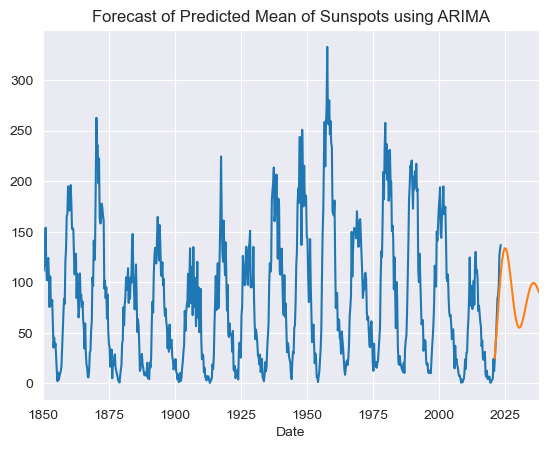

In [81]:
#Visualizing the forecast
ts_quarter.plot()
forecast_1.plot()
plt.title('Forecast of Predicted Mean of Sunspots using ARIMA')
plt.show()

In [82]:
# Now we'll try the SARIMA  model

In [83]:
model = sm.tsa.statespace.SARIMAX(ts_quarter, trend='n', order=(3,0,10), seasonal_order=(1,1,0,43))
results = model.fit()
print(results.summary())

C:\Users\maxsu\anaconda3_new\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                               counts   No. Observations:                  695
Model:             SARIMAX(3, 0, 10)x(1, 1, [], 43)   Log Likelihood               -3031.596
Date:                              Thu, 11 Apr 2024   AIC                           6093.191
Time:                                      18:45:48   BIC                           6160.392
Sample:                                  03-31-1850   HQIC                          6119.253
                                       - 09-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9031      0.121      7.472      0.000       0.666       1.140
ar.L2          0.79

In [85]:
#Buiding the forecast
forecast = results.predict(start = ts_quarter.index[-2], end= ts_quarter.index[-2] + pd.DateOffset(months=240), dynamic= True) 

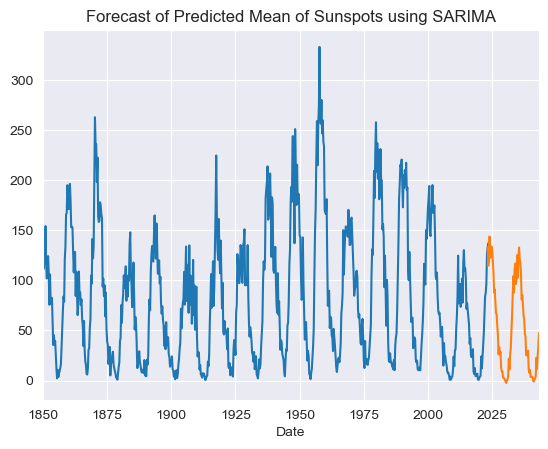

In [86]:
# VIsualizing the forecast
ts_quarter.plot()
forecast.plot()
plt.title('Forecast of Predicted Mean of Sunspots using SARIMA')
plt.show()

In [ ]:
# Based on the summary of each model  AND the analysis of the graphs shows that the SARIMA model 
#is going to give better predictions